In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [64]:
from langchain_community.document_loaders import ObsidianLoader

In [65]:
loader = ObsidianLoader(r"/mnt/c/Users/luisl/Documents/Life itself")
docs = loader.load()

In [66]:
print(f"Number of documents loaded: {len(docs)}")
print("\nFirst few documents preview:")
for i, doc in enumerate(docs[:3]):
    print(f"\nDocument {i+1}:")
    print(f"Source: {doc.metadata.get('source', 'No source')}")
    print(f"Content preview: {doc.page_content[:200]}...")

Number of documents loaded: 248

First few documents preview:

Document 1:
Source: Home 🛋️.md
Content preview: tags: [[Administración]]

[[Finanzas]]
[[Nutrición]]
- [[Lista de compras - mandado]]
- [[Ejercicio]]
- meal prep 
- desayuno, comida, cena

[[Goals]]
- comprarme una pc
- fashion
- dibujo

- [[Estudi...

Document 2:
Source: 1ero planes a futuro.md
Content preview: 2024-11-22 14:59

Status:

Tags: [[1. Raw/1ero trader|1ero trader]]

# 1ero planes a futuro


# Plan de Mejora del Proyecto
## 1. Brechas en Recolección de Información
### 1.1 Manejo de Información Te...

Document 3:
Source: 1ero trader mongoDB.md
Content preview: 2024-11-11 11:53

Status:

Tags: [[1. Raw/1ero trader]]

# 1ero trader mongoDB

Tickers
object example:
```JSON
{
  "_id": {
    "$oid": "651189993ed6e56a7ba6f49a"
  },
  "symbol": "IPOOF",
  "beta": ...


# Parsing functions (no langchain, llm involved)

In [6]:
def parse_obsidian_note(doc):
    """Parse a single Obsidian note and extract its components"""
    import re
    from datetime import datetime
    
    content = doc.page_content
    source = doc.metadata.get('source', 'No source')
    
    # Define regex patterns
    date_pattern = r"(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2})"
    status_pattern = r"Status:\s*#(\w+)"
    tags_pattern = r"Tags:\s*((?:\[\[.*?\]\](?:\s|$))*)"
    wikilink_pattern = r"\[\[(.*?)\]\]"
    title_pattern = r"#\s+(.+)$"
    
    # Extract components from the header section
    header_lines = content.split('\n# ')[0].split('\n')
    
    # Extract date, status, and tags from header
    date_match = re.search(date_pattern, '\n'.join(header_lines))
    date = datetime.strptime(date_match.group(1), "%Y-%m-%d %H:%M") if date_match else None
    
    status_match = re.search(status_pattern, '\n'.join(header_lines))
    status = status_match.group(1) if status_match else None
    
    tags_match = re.search(tags_pattern, '\n'.join(header_lines))
    tags = []
    if tags_match:
        tags_section = tags_match.group(1)
        tags = re.findall(wikilink_pattern, tags_section)
    
    # Extract title and content
    parts = content.split('\n# ', 1)
    if len(parts) > 1:
        # Content has a title
        title_and_content = parts[1]
        title_parts = title_and_content.split('\n', 1)
        title = title_parts[0].strip()
        actual_content = title_parts[1].strip() if len(title_parts) > 1 else ""
    else:
        # No title found
        title = "Untitled"
        actual_content = content.strip()
    
    clean_source = source.replace('.md', '') if source.endswith('.md') else source
    
    return {
        "date": date,
        "status": status,
        "tags": tags,
        "title": title,
        "source_path": doc.metadata.get('source', ''),
        "content": actual_content,
        "source": clean_source
    }

In [135]:
# Test the parser with first document
first_doc = docs[25]
parsed = parse_obsidian_note(first_doc)

print("Parsed Note:")
print(f"Date: {parsed['date']}")
print(f"Status: {parsed['status']}")
print(f"Tags: {parsed['tags']}")
print(f"Title: {parsed['title']}")
print(f"Source: {parsed['source']}")

print(f"actual_content: {parsed['content']}")

Parsed Note:
Date: None
Status: None
Tags: []
Title: Main goals
Source: Goals
actual_content: 1. Yo gano 60,000 al mes
2. Yo estoy titulado
3. Yo me ejercito y como bien
4. Yo no fumo ni consumo drogas o pornografia
5. Yo vivo con mi novia
6. convivo con mis mejores amigos seguido
7. Mi casa siempre esta limpia
8. Yo, mi ropa, mi piel y mi cabello siempre estan limpios 
9. Tengo carro
10. Mi familia esta bien
## Intelectual goals
##### Engineering
##### Med
##### Dibujo
##### [[Japanese guide]]
##### [[Nutrición]]
##### [[Ejercicio]]
##### [[Piano]]
## Material goals:
- PC nueva
- Fashion


# Extraction chain

In [58]:
from typing import Optional

from pydantic import BaseModel, Field


class note_analysis(BaseModel):
    """Information about a note subject."""

    main_concept: Optional[list[str]] = Field(
        default=None, description="the main concept of the note in the taxonomy"
    )
    is_school_note: Optional[bool] = Field(
        default=None, description="if the note is a school note"
    )
    is_map_of_content: Optional[bool] = Field(
        default=None, description="if the note is a map of content(meaning it leads to other notes related to the overall concept)"
    )

In [8]:
examples = [
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Implementing the Singleton Pattern in Django. Note Content: Tags: [[Singleton Pattern]] [[Python]] [[Django]] This note explores how to implement the Singleton design pattern in Python, specifically within a Django project. It covers the use of metaclasses and decorators to ensure that only one instance of a class is created. The note also discusses potential pitfalls and best practices when using the Singleton pattern in a web application context.",
        "answer": """
related_content_mentioned: ["Singleton Pattern", "Python", "Django"]
main_concept: ["TEC-PRO-PY", "TEC-PRO-SDP", "TEC-PRO-DJA"]
is_school_note: false
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Saving for a Down Payment. Note Content: Tags: [[Saving]] [[Investing]] [[Budgeting]] This note outlines my plan to save for a down payment on a house. It includes a detailed breakdown of my monthly budget, strategies for cutting expenses, and an analysis of potential investment options to accelerate savings. The goal is to reach the target within the next 5 years.",
        "answer": """
related_content_mentioned: ["Saving", "Investing", "Budgeting"]
main_concept: ["LIF-FIN-BUD", "LIF-FIN-INV", "LIF-GOA-LON"]
is_school_note: false
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Applying Atomic Habits to Daily Life. Note Content: Tags: [[Habit Formation]] [[Productivity]] [[Book Summary]] This note summarizes the key principles of the book \"Atomic Habits\" by James Clear. It explores how small changes in daily habits can lead to significant improvements over time. The note also provides practical tips for applying these principles to enhance productivity, achieve goals, and improve overall well-being.",
        "answer": """
related_content_mentioned: ["Habit Formation", "Productivity", "Book Summary"]
main_concept: ["PER-LEA", "PER-PRO", "LIF-ENT-BOO"]
is_school_note: false
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Controlling an LED Matrix with Arduino. Note Content: Tags: [[Arduino]] [[Electronics]] [[LED Matrix]] This note documents my project of building and programming an LED matrix display using an Arduino microcontroller. It covers the wiring diagram, the code for controlling individual LEDs, and techniques for creating animations and displaying text.",
        "answer": """
related_content_mentioned: ["Arduino", "Electronics", "LED Matrix"]
main_concept: ["TEC-ELE-COM", "TEC-PRO"]
is_school_note: false
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Deriving Backpropagation. Note Content: Tags: [[Backpropagation]] [[Neural Networks]] [[Calculus]] This note provides a detailed mathematical derivation of the backpropagation algorithm used for training artificial neural networks. It covers the chain rule of calculus and its application to calculating gradients for weight updates. The note also includes examples and visualizations to illustrate the concepts.",
        "answer": """
related_content_mentioned: ["Backpropagation", "Neural Networks", "Calculus"]
main_concept: ["TEC-ML-FOU", "TEC-MAT-CAL", "TEC-ML-ALG"]
is_school_note: false
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Mastering Composition in Digital Painting. Note Content: Tags: [[Art]] [[Digital Painting]] [[Composition]] This note focuses on improving composition in digital painting. It covers various compositional techniques such as the rule of thirds, leading lines, and balancing elements. It also includes exercises and examples to help develop an eye for creating visually appealing artwork.",
        "answer": """
related_content_mentioned: ["Art", "Digital Painting", "Composition"]
main_concept: ["PER-ART-FUN"]
is_school_note: false
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: The Mediterranean Diet Plan. Note Content: Tags: [[Nutrition]] [[Diet]] [[Meal Planning]] This note explores the principles of the Mediterranean diet, emphasizing whole grains, fruits, vegetables, and healthy fats. It discusses the health benefits associated with this dietary pattern and provides a sample 7-day meal plan with recipes.",
        "answer": """
related_content_mentioned: ["Nutrition", "Diet", "Meal Planning"]
main_concept: ["LIF-HEA-NUT"]
is_school_note: false
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Qualitative vs. Quantitative Research. Note Content: Tags: [[Research Methods]] [[Social Sciences]] This note compares and contrasts qualitative and quantitative research methodologies commonly used in the social sciences. It examines the strengths and weaknesses of each approach, including data collection techniques, analysis methods, and typical applications. The note also discusses mixed-methods research as a way to combine the benefits of both approaches.",
        "answer": """
related_content_mentioned: ["Research Methods", "Social Sciences"]
main_concept: ["PER-INF-RES-MET"]
is_school_note: false
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: My Weekly Cleaning Schedule. Note Content: Tags: [[Cleaning]] [[Home Maintenance]] [[Organization]] This note outlines my weekly cleaning schedule, designed to maintain a tidy and hygienic home environment. It includes a checklist of tasks for each day of the week, along with tips for efficient cleaning and recommended cleaning products.",
        "answer": """
related_content_mentioned: ["Cleaning", "Home Maintenance", "Organization"]
main_concept: ["LIF-HOM-HYG", "LIF-HOM-RES"]
is_school_note: false
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Quick Sort Complexity Analysis. Note Content: Tags: [[Algorithms]] [[Sorting]] [[Big O Notation]] This note analyzes the time and space complexity of the Quick Sort algorithm. It covers the best-case, average-case, and worst-case scenarios, using Big O notation to express the algorithm's efficiency. The note also includes a comparison with other sorting algorithms like Merge Sort and Bubble Sort.",
        "answer": """
related_content_mentioned: ["Algorithms", "Sorting", "Big O Notation"]
main_concept: ["TEC-PRO-ENG-ALG-SOR", "TEC-PRO-ENG-ALG-BIG"]
is_school_note: false
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Derechos humanos - bioetica. Note Content: # creación de la ONU y derechos humanos ### Intro: Características: - Traducido en 360 idiomas - Son intrínsecos - Son universales - Son inalienables",
        "answer": """
related_content_mentioned: []
main_concept: []
is_school_note: true
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Administración. Note Content: ### Datos mios [[Accounts]] [[Codigos - seguridad _ Security codes]] [[Codigo de fantastical calendar]] [[Cuenta de megacable]] [[Curriculum]] ### [[Finanzas]] [[Fiesta de graduación]] [[Resources/Compras]] [[Trabajo 💼]] - [[Quick airs]] - [[Hubspot - OpenAI]] ### [[Ideas relevantes]] - [[Improving]] - [[Posibles proyectos]] ## [[Estudiar]] ### Tecnologias ## [[ML]] #### [[Leetcode]] [[Web dev]] [[Django]] [[Electronica - HW]] [[Game dev]] [[Generative AI]] [[Matematicas]] ### [[Libros]] ### [[Language learning]] - [[Japon]] ### [[Entretenimiento 🎢]] - [[Juegos]] - [[Musica]] - [[Peliculas]] - [[Screenshots de cosas interesantes]] - [[Series]]",
        "answer": """
related_content_mentioned: ["Accounts", "Codigos - seguridad _ Security codes", "Codigo de fantastical calendar", "Cuenta de megacable", "Curriculum", "Finanzas", "Fiesta de graduación", "Resources/Compras", "Trabajo 💼", "Quick airs", "Hubspot - OpenAI", "Ideas relevantes", "Improving", "Posibles proyectos", "Estudiar", "Tecnologias", "ML", "Leetcode", "Web dev", "Django", "Electronica - HW", "Game dev", "Generative AI", "Matematicas", "Libros", "Language learning", "Japon", "Entretenimiento 🎢", "Juegos", "Musica", "Peliculas", "Screenshots de cosas interesantes", "Series"]
main_concept: []
is_school_note: false
is_map_of_content: true
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: HOME MOC CONTENT. Note Content: tags: [[Administración]] [[Finanzas]] [[Nutrición]] - [[Lista de compras - mandado]] - [[Ejercicio]] - meal prep - desayuno, comida, cena [[Goals]] - comprarme una pc - fashion - dibujo - [[Estudiar]] - [[Matematicas]] - [[ML]] - [[auto worker]] - Programacion - [[Learning Go lang]] - [[django portafolio]] - Medicina - [[Life manager]] - [[Japanese guide]] [[Entretenimiento 🎢]] - [[Musica]] - ver algo ([[Peliculas]], [[Mangas]]) - videos - [[Juegos]] Responsabķlidades - higiene del hogar - higiene personal - [[Servicio Social]] [[Ideas relevantes]] [[Libros]] [[Maxxing]]",
        "answer": """
related_content_mentioned: ["Administración", "Finanzas", "Nutrición", "Lista de compras - mandado", "Ejercicio", "Goals", "Estudiar", "Matematicas", "ML", "auto worker", "Learning Go lang", "django portafolio", "Medicina", "Life manager", "Japanese guide", "Entretenimiento 🎢", "Musica", "Peliculas", "Mangas", "Juegos", "Servicio Social", "Ideas relevantes", "Libros", "Maxxing"]
main_concept: []
is_school_note: false
is_map_of_content: true
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Ojecion de conciencia. Note Content: Este es nuestro infografico: ![[Business Project Infographic.png | 300]] ### Intro: **Ojecion de conciencia** Derecho a negarse a algo que no parece ser eticamente correcto Para los analisis debe haber *Cursos de accion* Transfusion a alguien que su religion no le deja Extremo Intermedios Extremo hacer transfucion, medicar la hemodialisis, dejar que muera",
        "answer": """
related_content_mentioned: ["Business Project Infographic.png"]
main_concept: []
is_school_note: true
is_map_of_content: false
""",
    },
{
        "question": "Analyze this note and extract the relevant information: Note Title: Craneotomo y mesas quirurgicas. Note Content: 2024-06-18 22:04 Status: #teen Tags: [[Biomedica 🔬]] # Craneotomo y mesas quirurgicas # Creaneotomo y mesas quirurgicas ### Intro: Un craneótomo es un instrumento quirúrgico especializado utilizado en neurocirugía para realizar craniotomías, que es el proceso de cortar un hueso del cráneo para acceder al cerebro. Este dispositivo permite a los cirujanos cortar un segmento de hueso, llamado colgajo óseo, de manera precisa y segura, minimizando el daño a los tejidos circundantes, incluyendo el cerebro y los vasos sanguíneos. ### Funcionamiento del Craneótomo El craneótomo combina las funciones de un taladro y una sierra en una sola herramienta, permitiendo perforar el cráneo y luego cortar el hueso siguiendo una trayectoria predefinida. Aquí se detalla cómo funciona: 1. **Inicio con un Taladro:** La operación comienza utilizando una broca especial en el craneótomo para perforar uno o varios agujeros en el cráneo, conocidos como \"agujeros de trépano\". Estos sirven como puntos de inicio y acceso para el corte del hueso. 2. **Corte del Hueso:** Después de perforar los agujeros de trépano, se cambia a una cuchilla de sierra circular o de otro tipo, dependiendo del diseño específico del craneótomo. El cirujano utiliza esta sierra para cortar el hueso del cráneo, conectando los puntos de los agujeros de trépano y siguiendo la trayectoria deseada para el colgajo óseo. 3. **Control y Precisión:** Los craneótomos modernos están diseñados para ofrecer un alto grado de control y precisión. Pueden incluir características como control de velocidad, protección contra la perforación excesiva (para prevenir daños en el tejido cerebral subyacente), y sistemas de aspiración para remover los residuos óseos y mantener clara la zona de trabajo. 4. **Seguridad:** Muchos craneótomos tienen sistemas de seguridad que detienen automáticamente el corte si la sierra entra en contacto con tejido blando, reduciendo así el riesgo de daño cerebral. ### Tipos de Craneótomo Existen varios tipos de craneótomos, que varían en diseño según el fabricante y el propósito específico. Algunos son manuales, mientras que otros son eléctricos o neumáticos. Los diseños pueden variar desde los más básicos, con una simple sierra y taladro, hasta los más avanzados con características como guiado por imagen y control de profundidad automatizado. ### Aplicaciones La principal aplicación del craneótomo es en la cirugía del cerebro, donde es crucial realizar cortes precisos y seguros en el cráneo para acceder al cerebro sin causar daño innecesario. Se utiliza en procedimientos como la eliminación de tumores cerebrales, la reparación de aneurismas, y las cirugías de epilepsia, entre otros. ### Fuentes La información proporcionada se basa en conocimientos generales sobre neurocirugía y el uso de instrumentos quirúrgicos especializados en este campo. Para obtener detalles más específicos y técnicos, se recomienda consultar fuentes médicas especializadas como: - \"Neurosurgery\" por Mark S. Greenberg. - \"Principles of Neurological Surgery\" por Richard G. Ellenbogen, Saleem I. Abdulrauf y Laligam N. Sekhar. Estas fuentes proporcionan una visión detallada y técnica del uso de craneótomos y otras herramientas en la neurocirugía, así como de los procedimientos quirúrgicos implicados. # Mesas quirurgicas Las mesas quirúrgicas son componentes esenciales en el entorno de la sala de operaciones, diseñadas para soportar al paciente durante un procedimiento quirúrgico, proporcionando tanto comodidad como la funcionalidad necesaria para el equipo quirúrgico. La evolución y el diseño de las mesas quirúrgicas han avanzado significativamente, ofreciendo una amplia gama de capacidades que facilitan una variedad de procedimientos quirúrgicos especializados. ### Diseño y Funcionalidad Las mesas quirúrgicas están diseñadas para ser altamente ajustables y versátiles, con características que incluyen: - **Ajuste de Altura:** Permite elevar o bajar la mesa para acomodar la altura del cirujano y facilitar el acceso quirúrgico. - **Inclinación Lateral:** Puede inclinarse de lado a lado para permitir el drenaje o mejorar el acceso quirúrgico a determinadas áreas del cuerpo. - **Trendelenburg y Reverso Trendelenburg:** Inclina al paciente hacia adelante o hacia atrás, respectivamente, lo cual puede ser necesario para procedimientos que requieren que la sangre se aleje o hacia la cabeza. - **Secciones Ajustables:** Las secciones de la mesa, como la cabeza, los pies y las piernas, pueden ser ajustables para diferentes procedimientos quirúrgicos, proporcionando el posicionamiento específico necesario. ### Tipos de Mesas Quirúrgicas Las mesas quirúrgicas pueden clasificarse según su funcionalidad y especialización, como: - **Mesas Generales:** Diseñadas para una amplia gama de procedimientos quirúrgicos. Son altamente versátiles y ajustables. - **Mesas Especializadas:** Diseñadas para tipos específicos de cirugía, como ortopedia, urología, y cirugía cardiotorácica, estas mesas pueden incluir accesorios y configuraciones especiales para facilitar procedimientos específicos. - **Mesas de Cirugía Mínimamente Invasiva:** Equipadas con características que facilitan las técnicas de cirugía mínimamente invasivas, como soportes para equipos de visualización y herramientas quirúrgicas. ### Tecnología e Innovación Las innovaciones tecnológicas han llevado a desarrollos significativos en el diseño de mesas quirúrgicas, incluyendo: - **Integración con Sistemas de Imagen:** Algunas mesas están diseñadas para integrarse con equipos de imagen, como C-arms, para permitir la visualización en tiempo real durante el procedimiento. - **Control Remoto y Automatización:** Las funciones de ajuste de la mesa pueden ser controladas remotamente, permitiendo al equipo quirúrgico realizar ajustes precisos fácilmente durante la cirugía. - **Materiales y Diseño Ergonómico:** Los materiales radiotransparentes permiten el uso de radiografías sin mover al paciente, y los diseños ergonómicos mejoran la comodidad del paciente y facilitan el acceso quirúrgico. ### Consideraciones de Seguridad y Confort El diseño de las mesas quirúrgicas también tiene en cuenta la seguridad y el confort del paciente, utilizando superficies y colchones que reducen el riesgo de úlceras por presión y permiten la correcta alineación y soporte del cuerpo durante procedimientos largos. ### Fuentes de Información Para una comprensión detallada y técnica de las mesas quirúrgicas y su evolución, se recomienda revisar literatura específica de equipos quirúrgicos y publicaciones médicas especializadas, como: - \"Surgical Technology: Principles and Practice\" por Joanna Kotcher Fuller. - Artículos y revisiones en revistas médicas especializadas en tecnología quirúrgica y manejo de salas de operaciones. Estas fuentes proporcionan información detallada sobre el diseño, la funcionalidad y las consideraciones clínicas de las mesas quirúrgicas en el entorno quirúrgico moderno.",
        "answer": """
related_content_mentioned: ["Biomedica 🔬"]
main_concept: []
is_school_note: true
is_map_of_content: false
""",
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Rutina de salud 🫀. Note Content: 2024-07-21 23:07 Status: #child Tags: [[Administración]] # Rutina de salud 🫀 [[everyday]] [[Goals]] ## Mental [[espiritualidad]] ## Física [[Nutrición]] [[Ejercicio]]",
        "answer": """
related_content_mentioned: ["Administración", "everyday", "Goals", "espiritualidad", "Nutrición", "Ejercicio"]
main_concept: ["LIF-HEA-EXE", "LIF-HEA-MEN", "LIF-HEA-NUT"]
is_school_note: false
is_map_of_content: false
""",
    },
]

In [63]:
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate

# First, create the example prompt template
example_prompt = PromptTemplate.from_template("""
Input: {question}
Output: {answer}
""")

# Then create the taxonomy prompt template
taxonomy_template = """You are a document classifier. Given a note's title and content, classify it according to our hierarchical taxonomy.
Return the analysis in the following format:

main_concept: [list of relevant category codes from taxonomy, maximum 3]
is_school_note: true/false
is_map_of_content: true/false

Use the following taxonomy for main_concept codes:
    - **Technical (TEC)**
        - Programming (TEC-PRO)
            - Languages (e.g., Python, JavaScript) (TEC-PRO-PY, TEC-PRO-JS)
            - Frameworks/Libraries (e.g., React, TensorFlow) (TEC-PRO-REA, TEC-PRO-TF)
            - Software Development Principles (e.g., Design Patterns, Agile) (TEC-PRO-SDP, TEC-PRO-AGL)
            - **Engineering Principles** (TEC-PRO-ENG)
                - **Algorithms** (TEC-PRO-ENG-ALG)
                    - **Sorting Algorithms** (TEC-PRO-ENG-ALG-SOR)
                    - **Big O Notation** (TEC-PRO-ENG-ALG-BIG)
        - Mathematics (TEC-MAT)
            - Pure Mathematics (e.g., Algebra, Calculus, Number Theory) (TEC-MAT-ALG, TEC-MAT-CAL, TEC-MAT-NUM)
            - Applied Mathematics (e.g., Statistics, Probability) (TEC-MAT-STA, TEC-MAT-PRO)
        - Machine Learning (TEC-ML)
            - Algorithms (e.g., Supervised, Unsupervised, Reinforcement) (TEC-ML-SUP, TEC-ML-UNS, TEC-ML-REI)
            - Applications (e.g., NLP, Computer Vision) (TEC-ML-NLP, TEC-ML-CV)
            - Tools & Technologies (e.g., PyTorch, Scikit-learn) (TEC-ML-PYT, TEC-ML-SCI)
            - **Foundations** (TEC-ML-FOU)
        - **Electronics** (TEC-ELE)
            - **Components & Connections** (TEC-ELE-COM)
        - **Software Engineering** (TEC-SOF)
            - **Practices** (TEC-SOF-PRA)
                - **Docker (macOS)** (TEC-SOF-PRA-DOC)
    - **Personal Development (PER)**
        - Learning & Cognition (PER-LEA)
            - Learning Strategies (e.g., Spaced Repetition, Active Recall) (PER-LEA-SPR, PER-LEA-ACR)
            - Cognitive Biases (PER-LEA-COG)
            - Memory Enhancement (PER-LEA-MEM)
        - Information Management (PER-INF)
            - Knowledge Management (PER-INF-KM)
            - Note-Taking (PER-INF-NOT)
            - Research & Synthesis (PER-INF-RES)
            - **Research Methodologies** (PER-INF-RES-MET)
        - Productivity & Time Management (PER-PRO)
            - Goal Setting (PER-PRO-GOA)
            - Time Blocking (PER-PRO-TIM)
            - Prioritization (PER-PRO-PRI)
        - **Artistic Development** (PER-ART)
            - **Fundamentals of Design** (PER-ART-FUN)
    - **Lifestyle (LIF)**
        - Health & Fitness (LIF-HEA)
            - Exercise & Training (LIF-HEA-EXE)
            - Nutrition & Diet (LIF-HEA-NUT)
            - Mental Wellbeing (LIF-HEA-MEN)
        - Finance (LIF-FIN)
            - Personal Budgeting (LIF-FIN-BUD)
            - Investing (LIF-FIN-INV)
            - Financial Planning (LIF-FIN-PLA)
        - Entertainment (LIF-ENT)
            - Books, Movies, Music (LIF-ENT-BOO, LIF-ENT-MOV, LIF-ENT-MUS)
            - Hobbies & Interests (LIF-ENT-HOB)
        - Personal Goals & Aspirations (LIF-GOA)
            - Short-Term Goals (LIF-GOA-SHO)
            - Long-Term Goals (LIF-GOA-LON)
            - Aspirations (LIF-GOA-ASP)
        - **Home & Personal Care** (LIF-HOM)
            - **Hygiene** (LIF-HOM-HYG)
            - **Responsibilities** (LIF-HOM-RES)

    some examples:
"""
suffix = """
    Now analyze this note:
    Title: {title}
    Content: {content}
    """

# Create the few-shot prompt template
few_shot_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=taxonomy_template,
    suffix=suffix,
    input_variables=["title", "content"]  # Removed 'examples' from here
)

# Test the prompt
print(
    few_shot_prompt.invoke({
        "title": "github", 
        "content": docs[125].page_content
    }).to_string()
)

You are a document classifier. Given a note's title and content, classify it according to our hierarchical taxonomy.
Return the analysis in the following format:

main_concept: [list of relevant category codes from taxonomy, maximum 3]
is_school_note: true/false
is_map_of_content: true/false

Use the following taxonomy for main_concept codes:
    - **Technical (TEC)**
        - Programming (TEC-PRO)
            - Languages (e.g., Python, JavaScript) (TEC-PRO-PY, TEC-PRO-JS)
            - Frameworks/Libraries (e.g., React, TensorFlow) (TEC-PRO-REA, TEC-PRO-TF)
            - Software Development Principles (e.g., Design Patterns, Agile) (TEC-PRO-SDP, TEC-PRO-AGL)
            - **Engineering Principles** (TEC-PRO-ENG)
                - **Algorithms** (TEC-PRO-ENG-ALG)
                    - **Sorting Algorithms** (TEC-PRO-ENG-ALG-SOR)
                    - **Big O Notation** (TEC-PRO-ENG-ALG-BIG)
        - Mathematics (TEC-MAT)
            - Pure Mathematics (e.g., Algebra, Calculus, Numbe

In [68]:
structured_llm = llm.with_structured_output(schema=note_analysis)

In [67]:
parsed_input = parse_obsidian_note(docs[125])
input = {"title": parsed_input['source'], "content": docs[125].page_content}
prompt = few_shot_prompt.invoke(input)
structured_llm.invoke(prompt)

note_analysis(main_concept=['PER-ART-FUN'], is_school_note=False, is_map_of_content=False)

In [12]:
def new_analyze_note(title, content):
    input = {"title": title, "content": content}
    prompt = few_shot_prompt.invoke(input)
    return structured_llm.invoke(prompt)

Goals
related_content_mentioned=['Japanese guide', 'Nutrición', 'Ejercicio'] main_concept=['LIF-GOA', 'LIF-HEA-NUT', 'LIF-HEA-EXE'] is_school_note=False is_map_of_content=False


In [72]:
import os

def transform_note(title, concepts, parsed):
    note_title = title
    clean_content = parsed['content']
    date = parsed['date']
    status = parsed['status']
    tags = parsed['tags']
    
    # Add safety checks for None values
    main_concepts = concepts.main_concept if concepts.main_concept else []  # Use empty list if None
    is_school_note = concepts.is_school_note
    is_map_of_content = concepts.is_map_of_content

    note_content = f"""---
created: {date}
status: {status}
tags: {' '.join(['School'] + main_concepts) if is_school_note else ' '.join(main_concepts)}
is_map_of_content: {is_map_of_content}
---

Direct-links: {' '.join([f'[[{tag}]]' for tag in tags])}
{clean_content}
"""

    vault_location = r"/mnt/c/Users/luisl/Documents/AI_Generated_Notes"
    file_path = os.path.join(vault_location, f"{parsed['source_path']}")
    os.makedirs(vault_location, exist_ok=True)
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(note_content)

    return note_content



In [144]:
# Process a single note
test_doc = docs[100]
parsed = parse_obsidian_note(test_doc)
concepts = new_analyze_note(parsed['source'], test_doc.page_content)

print(parsed['source'])
print(concepts)

new_note = transform_note(parsed['source'], concepts, parsed)
print(new_note)

Dinero disponible
related_content_mentioned=['Finanzas'] main_concept=['LIF-FIN', 'LIF-FIN-BUD'] is_school_note=False is_map_of_content=False
---
created: 2024-11-03 22:51:00
status: Adult
tags: LIF-FIN LIF-FIN-BUD
is_map_of_content: False
---

Direct-links: [[Finanzas]]
Related Content: [[Finanzas]]
efectivo: $5350
savings: $6,928
gabo: $2,100
madre: $7,300

nu: -17,971.21    (23 de septiembre)

didi prestamos: -3,538 (1 de octubre)
didi card: -1,889.24 (2 de octubre)


**===---- octubre 7 2024===**

dinero disponible: 21,515.98 +1200 pisto de tatis - 100 - 450
nu: 19,460.94 ==del 13 al 23 de octubre== 
didi: debo 979.23 y tengo 1,220.77 disponibles  ==del 17 de octubre al 2 de noviembre==
didi prestamos: 2,362 ==para primero de noviembre==


Deudas: 4562 (comprando el pisto con la nu) 

Gastos:
rentar un traje: 1400
uber: 600


==__---- octubre 21 2024__==

dinero disponible: 23,877 + 3,800 = 27,677
nu: 14,299 + 6,060 = 20,359
==total luego de la nu: 7,318==
didi: 2,116
didi prestamo

In [14]:
from uuid import uuid4
from datetime import datetime
from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_community.vectorstores.utils import filter_complex_metadata

vector_store = Chroma(
    collection_name="obsidian_jarvis",
    embedding_function=embeddings,
    persist_directory="./obsidian_jarvis_db",  # Where to save data locally, remove if not necessary
)

In [55]:
vector_store.reset_collection()

In [56]:
def add_to_vector_store(title, parsed, concepts, i):
    # Get note content directly from parsed dictionary
    note_content = parsed['content']
    doc_id = str(uuid4())
    
    # Create metadata and filter out complex values
    metadata = {
        "title": title,
        "last_modified": datetime.now().isoformat(),
        "tags": ", ".join(parsed['tags']), # Convert list to string
        "concepts": ", ".join(concepts.main_concept) if concepts.main_concept else "", # Convert list to string, handle empty list
        "id": i,
        "uuid": doc_id
    }
    

    
    # Create document first, then filter its metadata
    composed_doc = Document(page_content=note_content, metadata=metadata)
    filtered_doc = filter_complex_metadata([composed_doc])[0]
    
    vector_store.add_documents(documents=[filtered_doc], ids=[doc_id])

In [158]:
add_to_vector_store(parsed['source'], parsed, concepts)

In [57]:
retriever = vector_store.as_retriever(
    search_type="mmr", search_kwargs={"k": 5, "fetch_k": 10}
)
retriever.invoke("hay algo sobre ML?")

[]

In [160]:
vector_store.delete(ids=['527cff58-dfd4-451b-a617-40699128c1f9'])

In [73]:
for i, doc in enumerate(docs):
    parsed = parse_obsidian_note(doc)
    concepts = new_analyze_note(parsed['source'], doc.page_content)
    transform_note(parsed['source'], concepts, parsed)
    add_to_vector_store(parsed['source'], parsed, concepts, i) 

# loading a vector store and making a query and a retriever

In [20]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="obsidian_docs",
    embedding_function=embeddings,
    persist_directory="./chroma_obsidian_db",  # Where to save data locally, remove if not necessary
)

In [37]:


results = vector_store.similarity_search_with_score(
    "what can you tell me about langchain?", k=3,
)
for res, score in results:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]")


* [SIM=1.064987] Es una herramienta para controlar LLM's, por ejemplo si una LLM se usa para detectar queries de clientes que introducen texto indicando una cancion pero se necesita otra LLM para escribir la respuesta

[[Rag from scratch with langchain]] [{'concepts': 'TEC-PRO-ML', 'id': 150, 'last_modified': '2024-12-31T10:16:06.168243', 'tags': 'Lenguaje de progra', 'title': 'LangChain'}]
* [SIM=1.258699] ### Info:
Retrieval-augmented generation

this is a method to have a data store connected to the LLM in order to review information relevant to the prompt and be able to:
- source the data 
- update the data without retraining the model
- say "i dont know"


### Aprendizaje:
[[Rag from scratch with langchain]] [{'concepts': 'TEC-ML', 'id': 201, 'last_modified': '2024-12-31T10:18:15.399742', 'tags': 'ML', 'title': 'RAG'}]
* [SIM=1.545427] trabajos sobre

## 1. machine learning programming (fine tuning models and parameters)


## 2. LLM prompt engineering and [{'concepts': 'TEC-ML, TE

In [76]:
retriever = vector_store.as_retriever(
    search_type="mmr", search_kwargs={"k": 8, "fetch_k": 15}
)
retriever.invoke("do you have anything on prompts?")

[Document(metadata={'concepts': 'TEC-ML, TEC-ML-FOU, TEC-ML-AP', 'id': 70, 'last_modified': '2024-12-31T11:47:41.815783', 'tags': 'Generative AI', 'title': 'Claude', 'uuid': '9bfdc885-1149-4413-b2c5-a1c5185c5901'}, page_content="prompt for prompt engineering:\n```\nYou are an expert prompt engineer specializing in creating prompts for AI language models, particularly Claude 3.5 Sonnet.\n\nYour task is to take user input and transform it into well-crafted, effective prompts that will elicit optimal responses from Claude 3.5 Sonnet.\n\nWhen given input from a user, follow these steps:\n\n1. Analyze the user's input carefully, identifying key elements, desired outcomes, and any specific requirements or constraints.\n\n2. Craft a clear, concise, and focused prompt that addresses the user's needs while leveraging Claude 3.5 Sonnet's capabilities.\n\n3. Ensure the prompt is specific enough to guide Claude 3.5 Sonnet's response, but open-ended enough to allow for creative and comprehensive an

In [54]:
# Get all IDs from collection
all_ids = vector_store.get()["ids"]

In [51]:
uuids = [str(uuid4()) for _ in range(len(docs))]

In [52]:
vector_store.delete(ids=uuids[38])

Delete of nonexisting embedding ID: 8a3d1d8a-8fa3-48b8-bc8c-4ca9c42d773a
Delete of nonexisting embedding ID: 8a3d1d8a-8fa3-48b8-bc8c-4ca9c42d773a


# Crear modelo con context y hacerle una pregunta con el retrieve

In [27]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [28]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [29]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

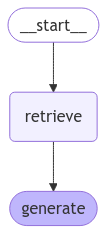

In [30]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
result = graph.invoke({"question": "what can you tell me about langchain?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'concepts': 'TEC-PRO-ML', 'id': 150, 'last_modified': '2024-12-31T10:16:06.168243', 'tags': 'Lenguaje de progra', 'title': 'LangChain'}, page_content="Es una herramienta para controlar LLM's, por ejemplo si una LLM se usa para detectar queries de clientes que introducen texto indicando una cancion pero se necesita otra LLM para escribir la respuesta\n\n[[Rag from scratch with langchain]]"), Document(metadata={'concepts': 'TEC-ML', 'id': 201, 'last_modified': '2024-12-31T10:18:15.399742', 'tags': 'ML', 'title': 'RAG'}, page_content='### Info:\nRetrieval-augmented generation\n\nthis is a method to have a data store connected to the LLM in order to review information relevant to the prompt and be able to:\n- source the data \n- update the data without retraining the model\n- say "i dont know"\n\n\n### Aprendizaje:\n[[Rag from scratch with langchain]]'), Document(metadata={'concepts': 'TEC-ML, TEC-PRO', 'id': 4, 'last_modified': '2024-12-31T10:10:43.771042', 't